In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import math
%matplotlib inline

pd.set_option('display.max_columns', 120)

In [4]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

In [6]:
with pd.HDFStore("./input/train.h5", "r") as train:
    # Note that the "train" dataframe is the only dataframe in the file
    df = train.get("train")

In [7]:
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,-0.179404,NaN,-0.072108,0.249187,0.024401,-0.127942,NaN,1.412742,-0.029575,1.265246,-0.055747,1.592256,-0.285275,-0.212888,0.404180,0.116903,0.197590,-0.197455,-0.195023,-0.059886,-0.021199,-0.013555,-0.236371,-0.253357,0.575562,0.283947,-0.006208,0.616351,-0.034578,0.732652,-0.002432,-0.092508,-0.072185,0.447296,-0.194318,0.264373,0.018763,NaN,-0.145278,-0.108547,0.148189,-0.226942,0.262864,-0.252933,-0.113265,0.180559,-0.033812,0.042951,-0.068031,0.208402,-0.082743,1.061059,1.120801,-0.228200,-0.119987,-0.131929,-0.145985,-0.155989,NaN,0.037680,NaN,NaN,-2.0,NaN,NaN,-2.0,-0.273957,NaN,-2.0,-2.0,NaN,0.001652,-2.0,NaN,-2.0,NaN,0.652981,0.000000,-0.142453,0.0,NaN,NaN,1.427469,NaN,-2.0,0.0,NaN,NaN,NaN,0.0,0.937880,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,0.216281,0.09675,0.082042,-0.224383,-0.085529,0.024763,-0.062337,-0.202247,1.746692,-0.187505,-0.034664,-0.135177,0.305562,0.027595,-0.208746,0.118520,-0.123511,0.113818,NaN,-0.115837,0.028282,0.076565,-0.217346,0.100054,0.358808,0.057505,0.025719,-0.141339,2.293476,0.024945,0.388208,-0.240927,-0.126232,-0.131619,0.232268,-0.001455,-0.489863,0.017317,0.027321,0.334183,0.113513,0.111536,-0.179379,0.221287,-0.091886,NaN,0.107982,0.548687,-0.160079,-0.281368,0.063933,-0.235643,-0.205083,-0.194349,-0.365186,0.041928,-0.044907,-0.039079,-0.075000,-0.280418,NaN,NaN,-2.0,NaN,NaN,-2.0,-0.159432,NaN,0.0,-2.0,NaN,0.004317,0.0,NaN,-2.0,NaN,-0.399520,0.000000,-0.309356,-0.5,NaN,NaN,0.154613,NaN,0.0,0.0,NaN,NaN,NaN,0.5,0.232154,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,NaN,NaN,-0.051418,-0.258330,-0.122140,-0.121041,-0.058287,-0.899515,-0.022131,-0.079002,-0.031116,-0.100603,-0.341474,-0.007522,0.077977,-0.149581,0.036946,0.166182,NaN,0.172751,0.961091,1.028205,-0.165369,0.056006,NaN,0.249530,-0.156078,NaN,0.019192,0.053364,-0.020247,NaN,0.064028,-0.249106,-0.106216,-0.085509,0.383589,NaN,-0.074021,-0.054295,-0.746073,-0.057605,-0.126238,0.462523,0.060902,NaN,-0.262892,-0.059395,0.562975,-0.026392,0.013430,-0.627150,-0.470362,-0.101865,0.436794,-0.057049,-0.120851,-0.061941,-0.600019,0.138357,NaN,NaN,-2.0,NaN,NaN,-2.0,-0.227811,NaN,-2.0,-2.0,NaN,0.000000,-2.0,NaN,-2.0,NaN,-0.496284,0.006942,0.122841,-0.5,NaN,NaN,0.378332,NaN,-2.0,

In [8]:
df.shape

(1710756, 111)

In [9]:
y_vals = df['y']

In [10]:
cumulative = y_vals.cumprod()

In [16]:
myv = y_vals.add(1)
cmyv = myv.cumprod()

0    0.988247
1    0.998760
2    0.979060
3    0.984041
4    0.992662
5    1.031425
6    0.967105
7    1.015803
8    0.972407
9    1.006662
Name: y, dtype: float32


In [11]:
type(cumulative)

pandas.core.series.Series

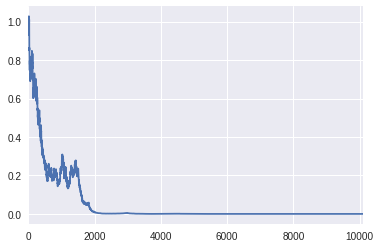

In [20]:
cmyv[:10099].plot()

In [39]:
d_median = df.median(axis=0)
n = df.isnull().sum(axis=1)
for c in df.columns:
    df[c + '_nan_'] = pd.isnull(df[c])
    d_median[c + '_nan_'] = 0
df = df.fillna(d_median)
df['znull'] = n
n = []

In [15]:
train = df[:806298]
val = df[806298:]

In [24]:
train_labels = train["y"]
val_labels = val["y"]
train_data = train.drop("y", 1)
val_data = val.drop("y", 1)

In [32]:
gbm = xgb.XGBRegressor(nthread=7, silent=False, n_estimators=300, learning_rate=.2)

In [33]:
gbm.fit(train_data, train_labels)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, nthread=7,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [40]:
predictions = gbm.predict(train_data)

In [47]:
print get_reward(predictions, train_labels)

-12.8572098866


In [41]:
print predictions[:50]

[  2.28205323e-03   2.20924616e-04  -6.90340996e-04  -4.36484814e-04
  -8.96215439e-04  -2.88927555e-03  -1.28966570e-03   1.14968419e-03
  -1.71458721e-03  -2.89607048e-03   3.89546156e-04  -1.47461891e-04
   2.20924616e-04  -1.42294168e-03   2.20924616e-04  -2.38996744e-03
  -6.77204132e-03  -2.09033489e-04  -3.52543592e-03   6.01619482e-04
   1.37555599e-03   1.29643083e-03   1.26177073e-03   3.49074602e-04
  -3.23724747e-03  -1.60336494e-04   6.50525093e-04  -3.46374512e-03
   1.83847845e-02  -9.81092453e-05   1.38613582e-03  -2.08004713e-02
  -7.42554665e-04   1.86413527e-04  -1.14046931e-02   4.69297171e-04
  -2.88665295e-03  -8.87292624e-03  -7.55250454e-04   1.29938126e-04
  -5.25808334e-03   1.99380517e-03   2.02363729e-03   1.12435222e-03
  -1.96284056e-03  -2.57462263e-03   1.70806646e-02   1.26177073e-03
  -7.13145733e-03  -9.85860825e-05]


In [42]:
print train_labels[:50]

0    -0.011753
1    -0.001240
2    -0.020940
3    -0.015959
4    -0.007338
5     0.031425
6    -0.032895
7     0.015803
8    -0.027593
9     0.006662
10   -0.001899
11    0.050219
12   -0.018991
13   -0.005203
14   -0.006369
15    0.017768
16   -0.001089
17   -0.008794
18    0.040724
19   -0.003921
20   -0.011317
21    0.044167
22    0.001395
23   -0.012101
24   -0.070837
25   -0.001766
26   -0.012542
27    0.029697
28    0.030815
29   -0.016336
30    0.041231
31   -0.086094
32   -0.019769
33   -0.019097
34   -0.042154
35    0.015426
36   -0.026304
37   -0.015709
38   -0.002253
39   -0.011964
40   -0.041490
41    0.016232
42   -0.020027
43   -0.003844
44   -0.024898
45   -0.013219
46    0.066793
47   -0.002048
48    0.000455
49   -0.023536
Name: y, dtype: float32
